<a href="https://colab.research.google.com/github/ritwiks9635/Object_Recognition_And_Detection-/blob/main/KeyPoints_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**🐕🐶🦮🐕‍🦺🐩Dogs Keypoints Detection 🐩🐕‍🦺🦮🐶🐕**

In [1]:
#https://www.kaggle.com/datasets/ukaszzaworski/dogs-keypoints-detection

In [ ]:
!unzip /content/https:/www.kaggle.com/datasets/ukaszzaworski/dogs-keypoints-detection/dogs-keypoints-detection.zip

In [ ]:
!pip install keras --upgrade

In [2]:
from keras import layers
import keras

from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as iaa

from PIL import Image
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json
import os

In [3]:
img_size = 224
batch_size = 32
epochs = 5
num_keypoints = 24 * 2

##**Load Data**

This metadata file that specifies additional information about the keypoints, like color information, animal pose name, etc.

In [4]:
img_dir = "/content/stanford-dogs/Images"
json_file = "/content/stanford-dogs/StanfordExtra_V12/StanfordExtra_v12.json"
keypoint_def = ("https://github.com/benjiebob/StanfordExtra/raw/master/keypoint_definitions.csv")

keypoint_df = pd.read_csv(keypoint_def)
keypoint_df.head()

,Index,Name,Hex colour,Stanford,Animal-pose,(name in animal pose)
0,0,Left front leg: paw,d82400,y,y,L_F_Paw
1,1,Left front leg: middle joint,d82400,y,y,L_F_Knee
2,2,Left front leg: top,d82400,y,y,L_F_Elbow
3,3,Left rear leg: paw,fcfc00,y,y,L_B_Paw
4,4,Left rear leg: middle joint,fcfc00,y,y,L_B_Knee


In [5]:
with open(json_file, "r") as f:
    json_data = json.load(f)
    print(json_data[0])

json_dict = {i["img_path"] : i for i in json_data}

{'img_path': 'n02085782-Japanese_spaniel/n02085782_2886.jpg', 'img_width': 350, 'img_height': 272, 'img_bbox': [205, 20, 116, 201], 'is_multiple_dogs': False, 'joints': [[108.66666666666667, 252.0, 1], [147.66666666666666, 229.0, 1], [163.5, 208.5, 1], [0, 0, 0], [0, 0, 0], [0, 0, 0], [54.0, 244.0, 1], [77.33333333333333, 225.33333333333334, 1], [79.0, 196.5, 1], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [150.66666666666666, 86.66666666666667, 1], [88.66666666666667, 73.0, 1], [116.0, 106.33333333333333, 1], [109.0, 123.33333333333333, 1], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], 'seg': 'Yi71c01S74jHNU75gHMX75eHM[74cHM\\76`HL4HQ7k0lHXOT7R1O2N010O010jLiNROW1m0lNROT1m0oNPOQ1P1QOoNn0R1ROnNn0oMkNQ2:Nl0oMlNQ2:0j0nMnNP291j0mMoNR280j0kMPOLEg1c0`0i0lMCb1Db0i0jMGa1Ae0h0iMI`1_Og0j0fMK`1\\Oj0i0eMN^1ZOl0i0dM1]1WOm0k0cM2]1TOP1j0bM4\\1ROR1k0`M<W1iNX1l0`M=:ZN4=Q2T3aMXLO8>=Q2k3oMULQ2k3oMTLQ2m3mMULS2j3mMWLS2i3kMYLT2h3kMYLU2f3lMYLT2h3jMYLV2i3hMXLW2j3dMZL\\2k42O1O10

A single entry of `json_dict` looks like the following:

```
'n02085782-Japanese_spaniel/n02085782_2886.jpg':
{'img_bbox': [205, 20, 116, 201],
 'img_height': 272,
 'img_path': 'n02085782-Japanese_spaniel/n02085782_2886.jpg',
 'img_width': 350,
 'is_multiple_dogs': False,
 'joints': [[108.66666666666667, 252.0, 1],
            [147.66666666666666, 229.0, 1],
            [163.5, 208.5, 1],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [54.0, 244.0, 1],
            [77.33333333333333, 225.33333333333334, 1],
            [79.0, 196.5, 1],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [150.66666666666666, 86.66666666666667, 1],
            [88.66666666666667, 73.0, 1],
            [116.0, 106.33333333333333, 1],
            [109.0, 123.33333333333333, 1],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0]],
 'seg': ...}
```



In this example, the keys we are interested in are:

* `img_path`
* `joints`

There are a total of 24 entries present inside `joints`. Each entry has 3 values:

* x-coordinate
* y-coordinate
* visibility flag of the keypoints (1 indicates visibility and 0 indicates non-visibility)

As we can see `joints` contain multiple `[0, 0, 0]` entries which denote that those
keypoints were not labeled. In this example, we will consider both non-visible as well as
unlabeled keypoints in order to allow mini-batch learning.

In [6]:
colours = keypoint_df["Hex colour"].values.tolist()
colours = ["#" + colour for colour in colours]
labels = keypoint_df["Name"].values.tolist()

def load_data(name):
    data = json_dict[name]
    img_path = os.path.join(img_dir, data["img_path"])
    images = plt.imread(img_path)
    if images.shape[-1] == 4:
        images = images.astype(np.uint8)
        images = Image.fromarray(images)
        images = np.array(images.convert("RGB"))
    data["img_data"] = images
    return data

##**Visualize data**

In [7]:
def visualize_keypoints(images, keypoints):
    fig, axes = plt.subplots(nrows=len(images), ncols=2, figsize=(16, 12))
    [ax.axis("off") for ax in np.ravel(axes)]

    for (ax_orig, ax_all), image, current_keypoint in zip(axes, images, keypoints):
        ax_orig.imshow(image)
        ax_all.imshow(image)

        # If the keypoints were formed by `imgaug` then the coordinates need
        # to be iterated differently.
        if isinstance(current_keypoint, KeypointsOnImage):
            for idx, kp in enumerate(current_keypoint.keypoints):
                ax_all.scatter(
                    [kp.x],
                    [kp.y],
                    c=colours[idx],
                    marker="x",
                    s=50,
                    linewidths=5,
                )
        else:
            current_keypoint = np.array(current_keypoint)
            # Since the last entry is the visibility flag, we discard it.
            current_keypoint = current_keypoint[:, :2]
            for idx, (x, y) in enumerate(current_keypoint):
                ax_all.scatter([x], [y], c=colours[idx], marker="x", s=50, linewidth = 5)
    plt.tight_layout(pad=2.0)
    plt.show()

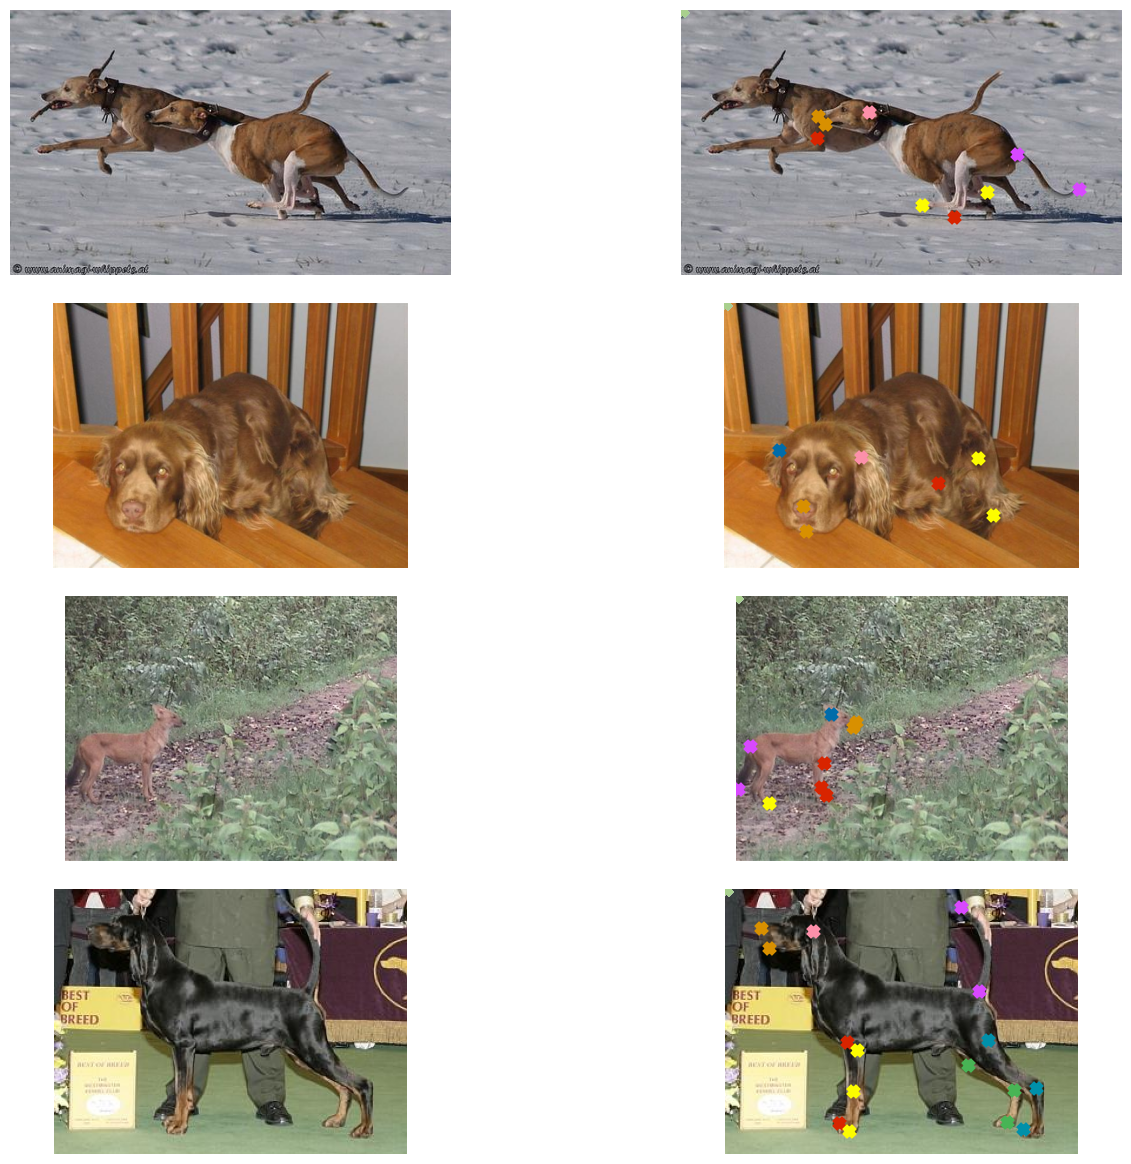

In [8]:
samples = list(json_dict.keys())
num_samples = 4

random_samples = np.random.choice(samples, num_samples, replace = False)

images = []
keypoints = []

for sample in random_samples:
    data = load_data(sample)
    image = data["img_data"]
    keypoint = data["joints"]


    images.append(image)
    keypoints.append(keypoint)

visualize_keypoints(images, keypoints)

##**Data Generator**

In [9]:
class KeyPointsDataset(keras.utils.PyDataset):
    def __init__(self, img_keys, aug, batch_size = batch_size, train = True, **kwargs):
        super().__init__(**kwargs)
        self.img_keys = img_keys
        self.aug = aug
        self.batch_size = batch_size
        self.train = train
        self.on_epoch_end()


    def __len__(self):
        return len(self.img_keys) // self.batch_size


    def on_epoch_end(self):
        self.indexes = np.arange(len(self.img_keys))
        if self.train:
            np.random.shuffle(self.indexes)


    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        image_keys_temp = [self.img_keys[k] for k in indexes]
        (images, keypoints) = self.__data_generation(image_keys_temp)

        return (images, keypoints)


    def __data_generation(self, image_keys_temp):
        batch_images = np.empty((self.batch_size, img_size, img_size, 3), dtype="int")
        batch_keypoints = np.empty((self.batch_size, 1, 1, num_keypoints), dtype="float32")

        for i, key in enumerate(image_keys_temp):
            data = load_data(key)
            current_keypoint = np.array(data["joints"])[:, :2]
            kps = []

            # To apply our data augmentation pipeline, we first need to
            # form Keypoint objects with the original coordinates.
            for j in range(0, len(current_keypoint)):
                kps.append(Keypoint(x=current_keypoint[j][0], y=current_keypoint[j][1]))

            # We then project the original image and its keypoint coordinates.
            current_image = data["img_data"]
            kps_obj = KeypointsOnImage(kps, shape=current_image.shape)

            # Apply the augmentation pipeline.
            (new_image, new_kps_obj) = self.aug(image=current_image, keypoints=kps_obj)
            batch_images[i,] = new_image

            # Parse the coordinates from the new keypoint object.
            kp_temp = []
            for keypoint in new_kps_obj:
                kp_temp.append(np.nan_to_num(keypoint.x))
                kp_temp.append(np.nan_to_num(keypoint.y))

            # More on why this reshaping later.
            batch_keypoints[i,] = np.array(kp_temp).reshape(1, 1, 24 * 2)

        # Scale the coordinates to [0, 1] range.
        batch_keypoints = batch_keypoints / img_size
        return (batch_images, batch_keypoints)

##**Data Augmentation**

In [10]:
train_aug = iaa.Sequential(
    [
        iaa.Resize(img_size, interpolation="linear"),
        iaa.Fliplr(0.3),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        iaa.Sometimes(0.3, iaa.Affine(rotate=10, scale=(0.5, 0.7))),
    ])

test_aug = iaa.Sequential([iaa.Resize(img_size, interpolation="linear")])

##**Training and Validation splits**

In [11]:
np.random.shuffle(samples)

train_keys, valid_keys = (
    samples[int(len(samples) * 0.15) :],
    samples[: int(len(samples) * 0.15)]
    )

In [12]:
print("Total train keys is ::", len(train_keys))
print("Total valid keys is ::", len(valid_keys))

Total train keys is :: 10658
Total valid keys is :: 1880


Total batches in training set: 333
Total batches in validation set: 58


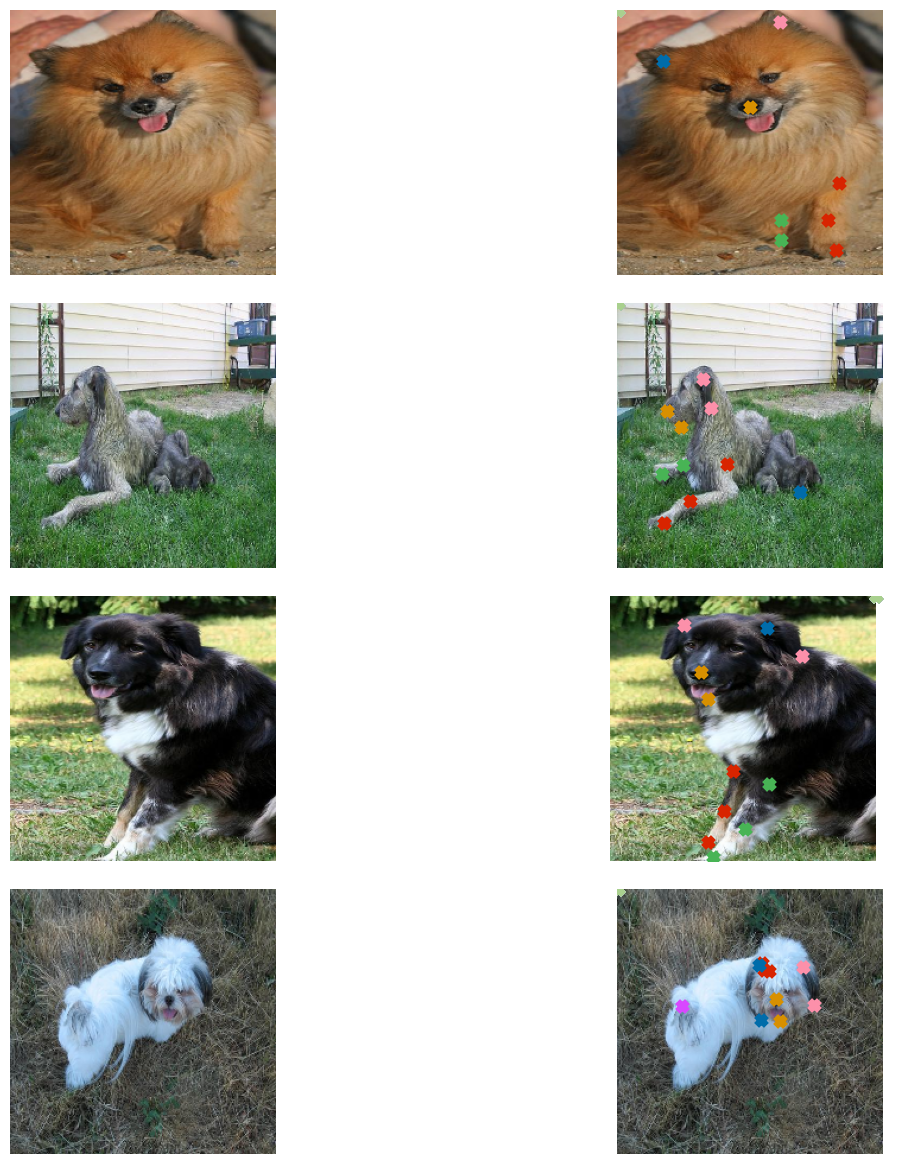

In [13]:
train_dataset = KeyPointsDataset(train_keys, train_aug, workers=2, use_multiprocessing=True)

valid_dataset = KeyPointsDataset(valid_keys, test_aug, train=False, workers=2, use_multiprocessing=True)

print(f"Total batches in training set: {len(train_dataset)}")
print(f"Total batches in validation set: {len(valid_dataset)}")

sample_images, sample_keypoints = next(iter(train_dataset))
assert sample_keypoints.max() == 1.0
assert sample_keypoints.min() == 0.0

sample_keypoints = sample_keypoints[:4].reshape(-1, 24, 2) * img_size
visualize_keypoints(sample_images[:4], sample_keypoints)

In [14]:
def get_model():
    backbone = keras.applications.MobileNetV2(
        weights = "imagenet",
        input_shape = (img_size, img_size, 3),
        include_top = False)

    backbone.trainable = False

    inputs = keras.Input(shape = (img_size, img_size, 3))
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)
    x = layers.SeparableConv2D(num_keypoints, kernel_size = 5, strides = 1, activation = "relu")(x)
    outputs = layers.SeparableConv2D(num_keypoints, kernel_size = 3, strides = 1, activation = "sigmoid")(x)
    model = keras.Model(inputs, outputs)
    return model

In [15]:
model = get_model()
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 7, 1280)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d (SeparableConv2D)   │ (None, 3, 3, 48)            │          93,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_1 (SeparableConv2D) │ (None, 1, 1, 48)            │           2,784 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,354,256 (8.98 MB)

 Trainable params: 96,272 (376.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

**Notice the output shape of the network: (None, 1, 1, 48). This is why we have reshaped the coordinates as: batch_keypoints[i, :] = np.array(kp_temp).reshape(1, 1, 24 * 2).**

In [16]:
model.compile(optimizer = keras.optimizers.Adam(1e-4), loss = "mse")

model.fit(train_dataset, validation_data = valid_dataset, epochs = epochs)

Epoch 1/5


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


333/333 ━━━━━━━━━━━━━━━━━━━━ 162s 402ms/step - loss: 0.1038 - val_loss: 0.0804
Epoch 2/5
333/333 ━━━━━━━━━━━━━━━━━━━━ 156s 462ms/step - loss: 0.0770 - val_loss: 0.0754
Epoch 3/5
333/333 ━━━━━━━━━━━━━━━━━━━━ 146s 430ms/step - loss: 0.0741 - val_loss: 0.0725
Epoch 4/5
333/333 ━━━━━━━━━━━━━━━━━━━━ 148s 437ms/step - loss: 0.0729 - val_loss: 0.0694
Epoch 5/5
333/333 ━━━━━━━━━━━━━━━━━━━━ 187s 388ms/step - loss: 0.0710 - val_loss: 0.0676


##**Prediction**

If train >= 20 Epochs so get Better result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
================ Ground Truth ================


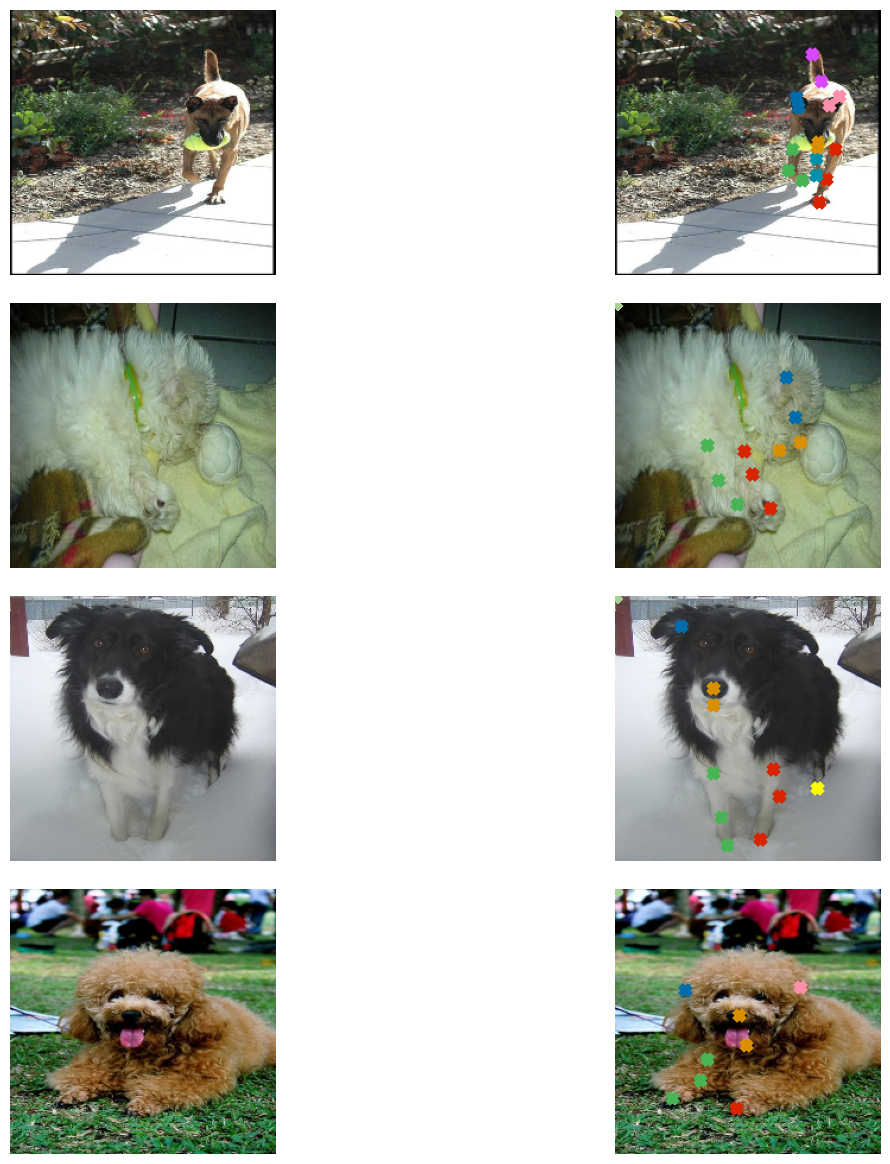

================ Prediction Points ================


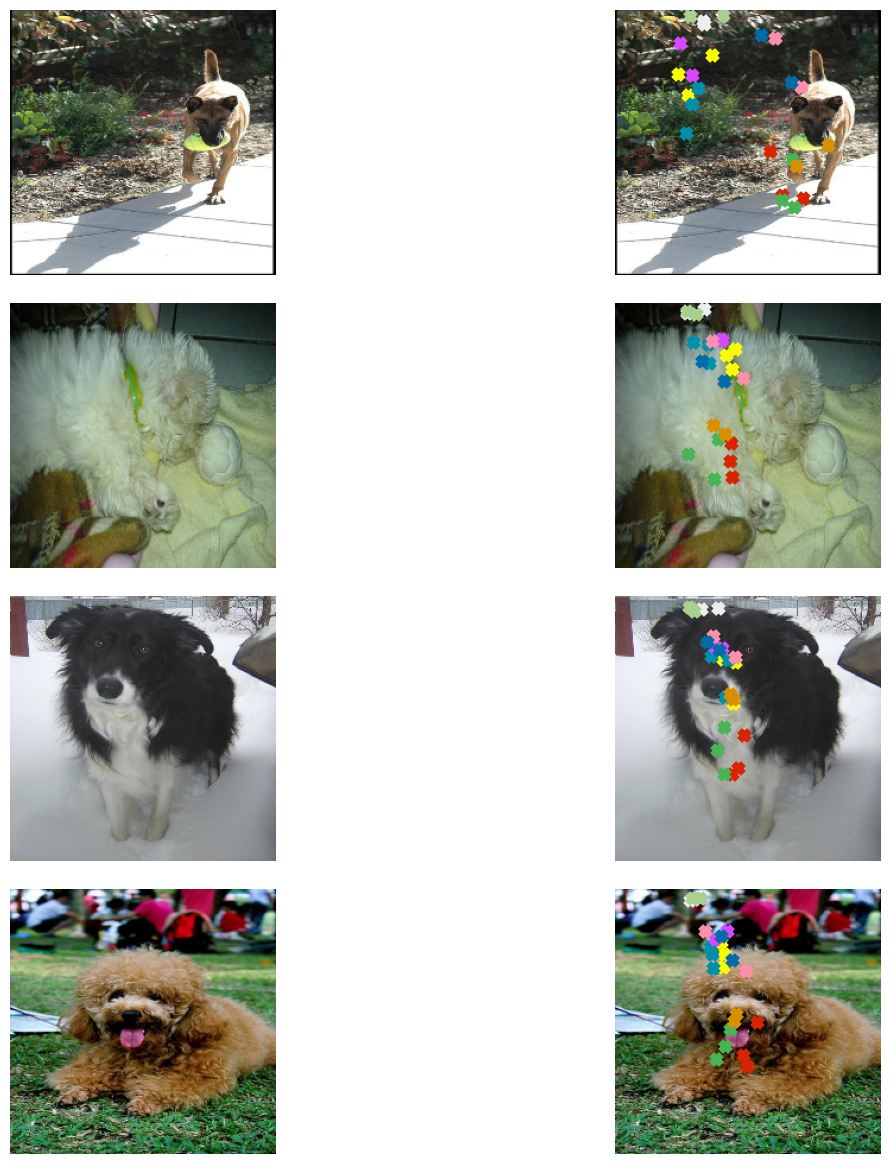

In [27]:
sample_img, sample_keypoint = next(iter(valid_dataset))
sample_img = sample_img[:4]
sample_keypoint = sample_keypoint[:4].reshape(-1, 24, 2) * img_size
pred_points = model.predict(sample_img).reshape(-1, 24, 2) * img_size

print("==" * 8, "Ground Truth", "==" * 8)
visualize_keypoints(sample_img, sample_keypoint)

print("==" * 8, "Prediction Points", "==" * 8)
visualize_keypoints(sample_img, pred_points)